## UKBB+HCP Exploratory Data Analysis

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-01-14 14:51:24.277270: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 14:51:25.849271: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-14 14:51:27.997825: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from models import *
from data import * 
from env import *
from harmonize import *
from sim import *

In [4]:
# overall imports
import importlib
import data

# data load
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
importlib.reload(data.data_load)
importlib.reload(data.data_viz)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_shared_matrices,
    process_cv_splits,  
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# sim class
import sim.sim 
from sim.sim import Simulation
importlib.reload(sim.sim)


<module 'sim.sim' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim.py'>

## Load in structural connectomes

In [5]:
HCP_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/HCP1200_DTI/'
print(HCP_path)

/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_DTI/


In [6]:
# Load stuctural connectome from ENIGMA
HCP_enigma_structural_count = load_connectome(measure='SC', omit_subcortical=False)
HCP_enigma_structural_count_cortical = HCP_enigma_structural_count[:100, :100]

# Load 156-region structural connectivity matrices
HCP1200_S156_structural_count = np.log1p(loadmat(HCP_path + '/4S156/4S156_DTI_count.mat')['connectivity'])
HCP1200_S156_structural_count_cortical = HCP1200_S156_structural_count[:100, :100]
HCP1200_S156_structural_QA = loadmat(HCP_path + '/4S156/4S156_DTI_QA.mat')['connectivity']
HCP1200_S156_structural_QA_cortical = HCP1200_S156_structural_QA[:100, :100]

# Load 456-region structural connectivity matrices  
HCP1200_S456_structural_count = np.log1p(loadmat(HCP_path + '/4S456/4S456_DTI_count.mat')['connectivity'])
HCP1200_S456_structural_count_cortical = HCP1200_S456_structural_count[:400, :400]
HCP1200_S456_structural_QA = loadmat(HCP_path + '/4S456/4S456_DTI_QA.mat')['connectivity']
HCP1200_S456_structural_QA_cortical = HCP1200_S456_structural_QA[:400, :400]


## Load in functional connectomes

In [14]:
UKBB_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/Penn_UKBB_data/'
print(UKBB_path)

UKBB_demographics = pd.read_csv(UKBB_path + '/metadata/UKBB_MasterList_DemogInfo_part.csv')
UKBB_demographics.head()

/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/


MRID    Age  IsF     Race
0  1000038_2_0  64.64  1.0  British
1  1000108_2_0  68.39  0.0  British
2  1000149_2_0  76.67  0.0    Irish
3  1000201_2_0  67.24  1.0  British
4  1000213_2_0  67.73  1.0  British

In [15]:
UKBB_S156_functional_conn = pd.read_csv('./data/UKBB/UKBB_S156_functional_conn.csv')
UKBB_S156_functional_conn_cortical = np.array(UKBB_S156_functional_conn)[:100, :100]
UKBB_S156_labels = pd.read_csv('./data/UKBB/schaefer156_atlas_info.txt', sep='\t')['label_7network'].tolist()

UKBB_S456_functional_conn = pd.read_csv('./data/UKBB/UKBB_S456_functional_conn.csv')
UKBB_S456_functional_conn_cortical = np.array(UKBB_S456_functional_conn)[:400, :400]
UKBB_S456_labels = pd.read_csv('./data/UKBB/schaefer456_atlas_info.txt', sep='\t')['label_7network'].tolist()

HCP_enigma_functional_conn = load_connectome(measure='FC', omit_subcortical=False)
HCP_enigma_functional_conn_cortical = load_connectome(measure='FC', omit_subcortical=True)
HCP_labels = pd.read_csv('./data/enigma/schaef114_regions.txt', header=None).values.flatten().tolist()


### Structure-function correlations

ENIGMA

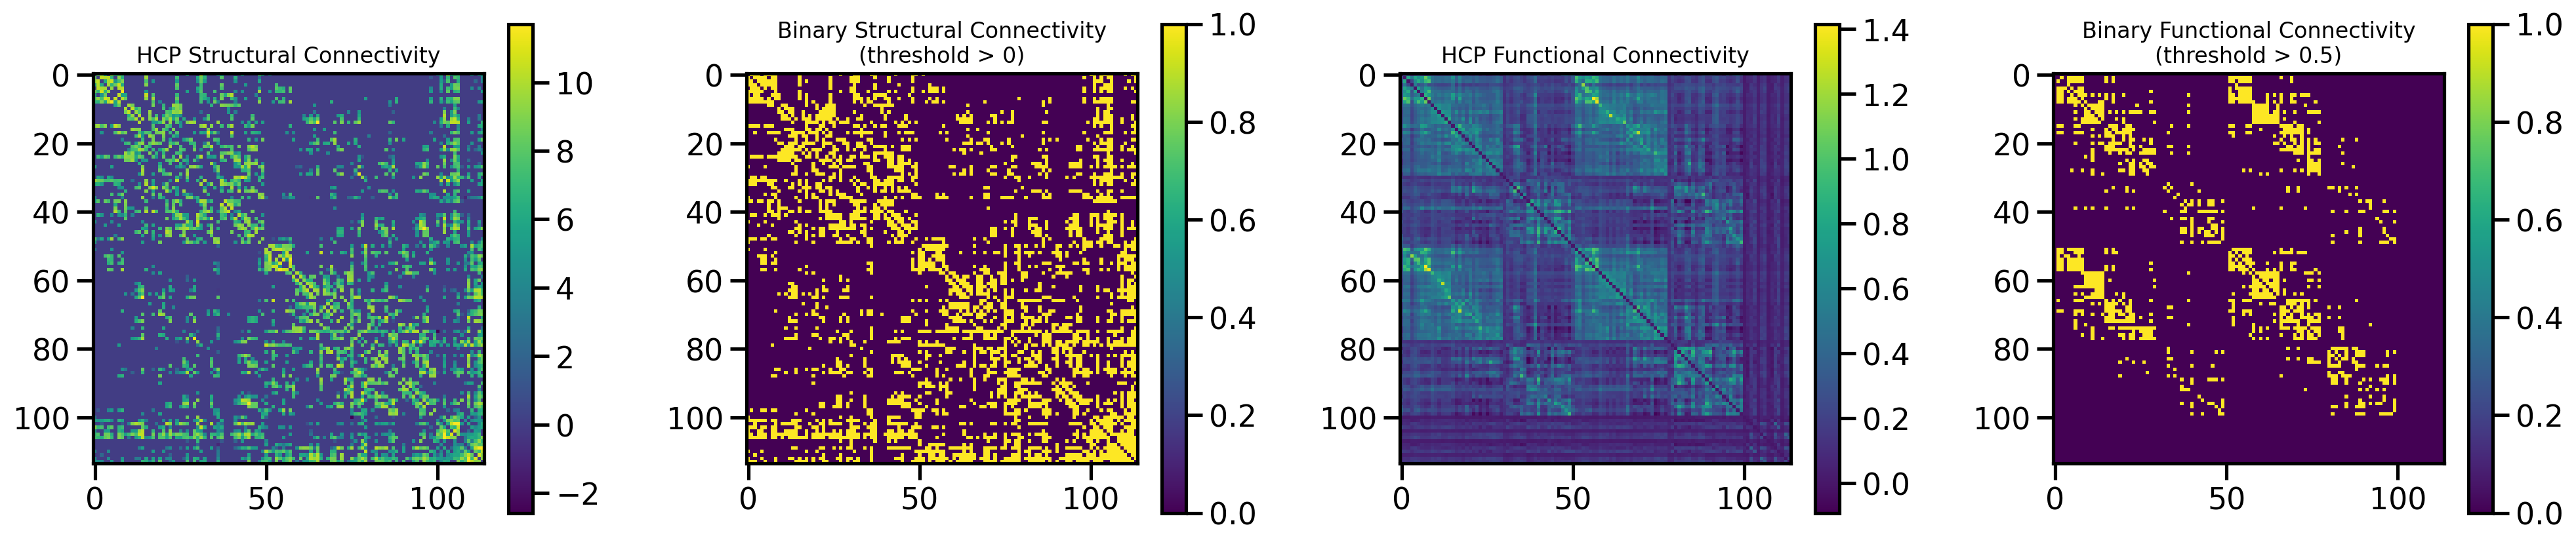

Structure-Function Correlation: 0.173
Binary Structure-Function Correlation: 0.154


In [16]:
# Create binary versions of connectomes
binary_structural = (HCP_enigma_structural_count > 0).astype(int)
fc_median = np.median(HCP_enigma_functional_conn)

binary_functional = (HCP_enigma_functional_conn > 0.5).astype(int)

# Set up figure with 4 subplots
plt.figure(figsize=(20,8), dpi=200)  # Increased width to fit 4 plots

# Original structural connectivity
plt.subplot(141)
plt.imshow(HCP_enigma_structural_count, cmap='viridis', interpolation='nearest')
plt.colorbar(shrink=0.5)
plt.title('HCP Structural Connectivity', fontsize=12)

# Binary structural connectivity
plt.subplot(142)
plt.imshow(binary_structural, cmap='viridis', interpolation='nearest')
plt.colorbar(shrink=0.5)
plt.title('Binary Structural Connectivity\n(threshold > 0)', fontsize=12)

# Original functional connectivity
plt.subplot(143)
plt.imshow(HCP_enigma_functional_conn, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('HCP Functional Connectivity', fontsize=12)

# Binary functional connectivity
plt.subplot(144)
plt.imshow(binary_functional, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('Binary Functional Connectivity\n(threshold > 0.5)', fontsize=12)

plt.tight_layout()
plt.show()

# Compute correlation between structural and functional connectivity
struct_func_corr = np.corrcoef(HCP_enigma_structural_count.flatten(), 
                              HCP_enigma_functional_conn.flatten())[0,1]
                              
print(f"Structure-Function Correlation: {struct_func_corr:.3f}")

# Compute correlation between binary versions
binary_corr = np.corrcoef(binary_structural.flatten(),
                         binary_functional.flatten())[0,1]
                         
print(f"Binary Structure-Function Correlation: {binary_corr:.3f}")


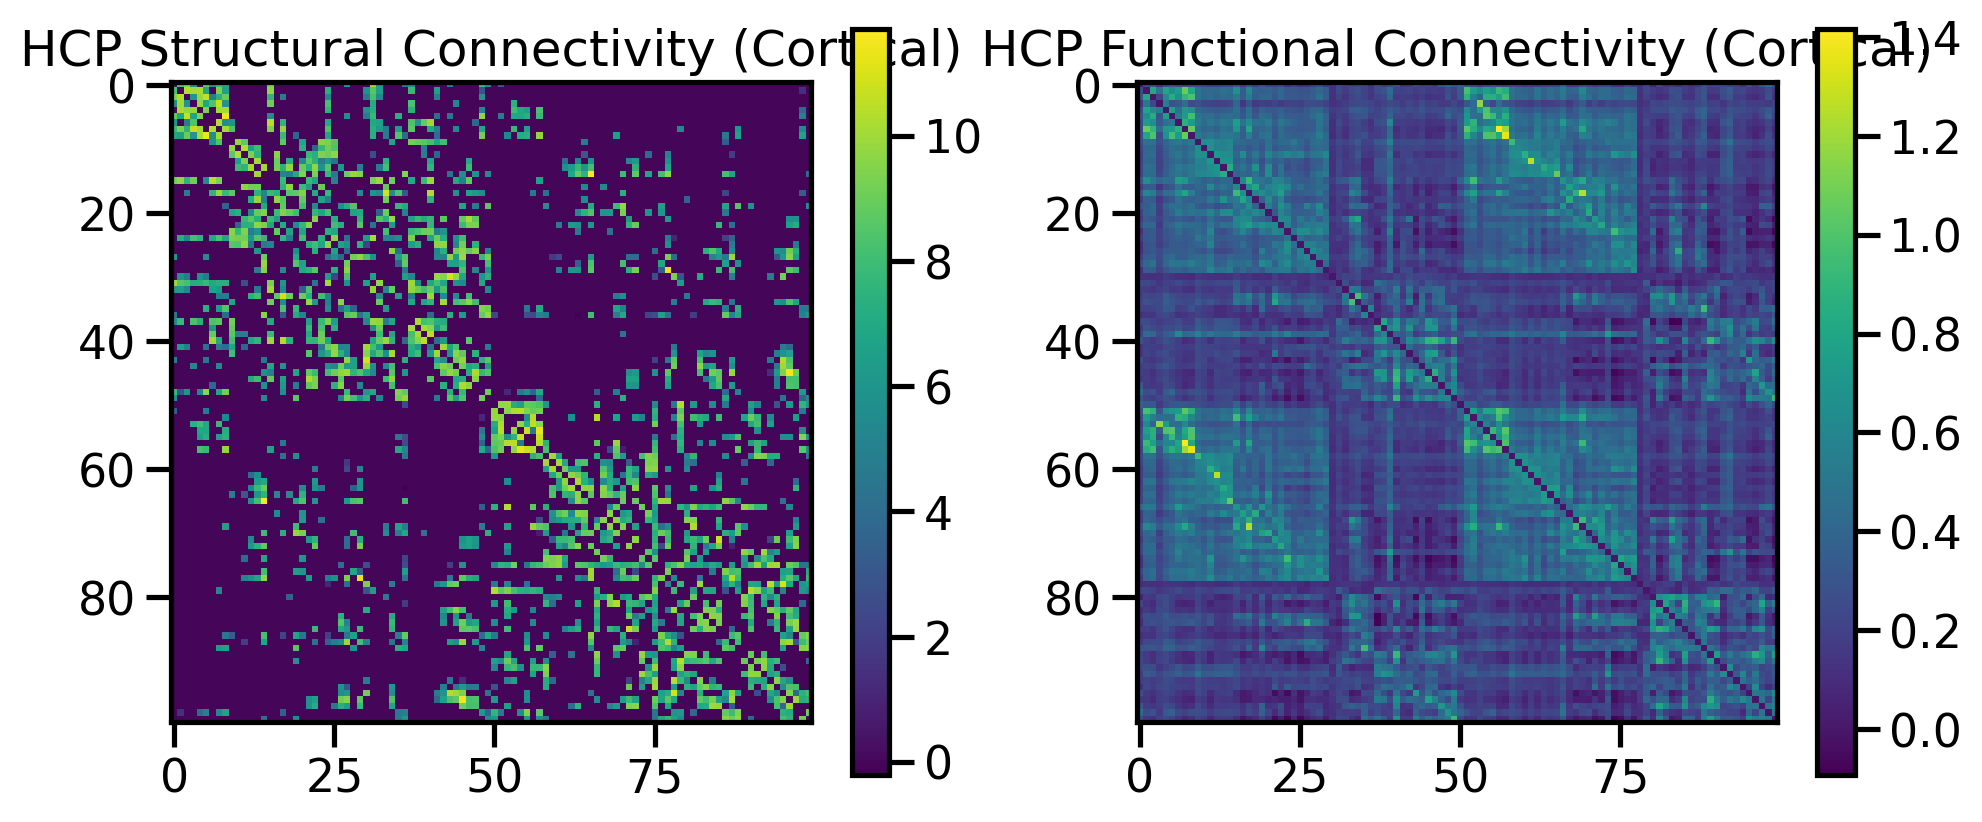

Structure-Function Correlation (Cortical): 0.268


In [17]:
# Visualize structural connectivity matrix
plt.figure(figsize=(10,8), dpi=200)
plt.subplot(121)
plt.imshow(HCP_enigma_structural_count_cortical, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('HCP Structural Connectivity (Cortical)')

# Visualize functional connectivity matrix
plt.subplot(122)
plt.imshow(HCP_enigma_functional_conn_cortical, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('HCP Functional Connectivity (Cortical)')
plt.tight_layout()
plt.show()

# Compute correlation between structural and functional connectivity
struct_func_corr = np.corrcoef(HCP_enigma_structural_count_cortical.flatten(), 
                              HCP_enigma_functional_conn_cortical.flatten())[0,1]
                              
print(f"Structure-Function Correlation (Cortical): {struct_func_corr:.3f}")


HCP1200-UKBB

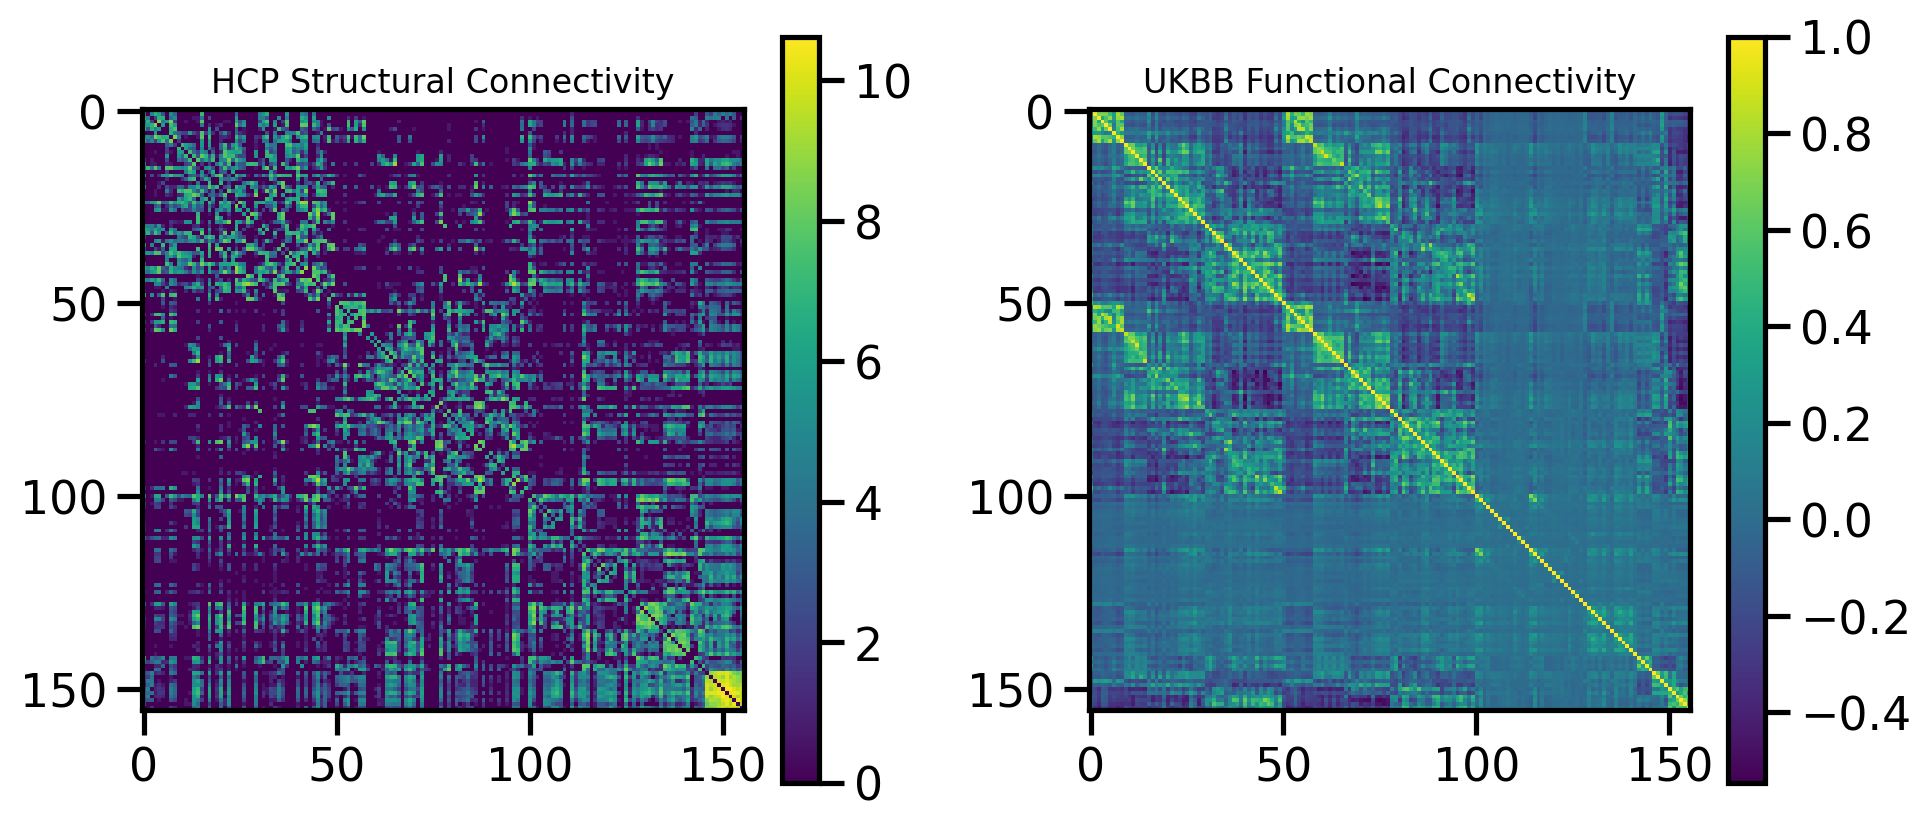

HCP Structure - UKBB Function Correlation: 0.166


In [18]:
# Visualize structural connectivity matrix from HCP and functional from UKBB
plt.figure(figsize=(10,8), dpi=200)
plt.subplot(121)
plt.imshow(HCP1200_S156_structural_count, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('HCP Structural Connectivity', fontsize=12)

plt.subplot(122)
plt.imshow(UKBB_S156_functional_conn, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('UKBB Functional Connectivity', fontsize=12)
plt.tight_layout()
plt.show()

# Compute correlation between HCP structural and UKBB functional connectivity
struct_func_corr = np.corrcoef(np.array(HCP1200_S156_structural_count).flatten(),
                              np.array(UKBB_S156_functional_conn).flatten())[0,1]

print(f"HCP Structure - UKBB Function Correlation: {struct_func_corr:.3f}")


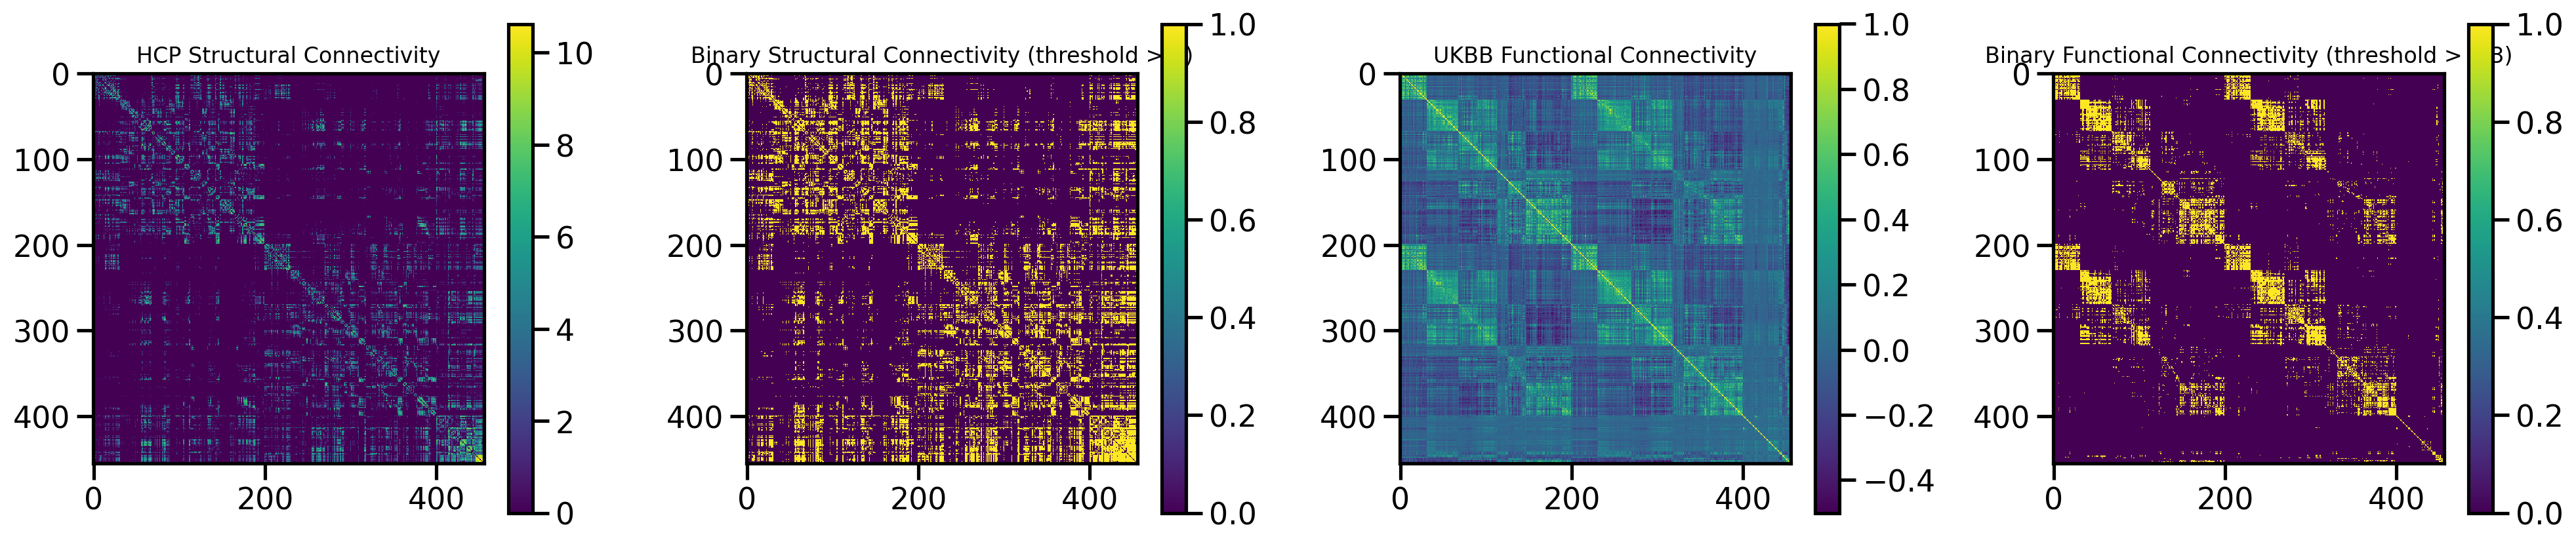

Structure-Function Correlation: 0.180
Binary Structure-Function Correlation: 0.122


In [19]:
# Create binary versions of connectomes
binary_structural = (HCP1200_S456_structural_count > 0).astype(int)
fc_median = np.median(UKBB_S456_functional_conn)
binary_functional = (UKBB_S456_functional_conn > 0.3).astype(int)

# Set up figure with 4 subplots
plt.figure(figsize=(20,8), dpi=200)  # Increased width to fit 4 plots

# Original structural connectivity
plt.subplot(141)
plt.imshow(HCP1200_S456_structural_count, cmap='viridis', interpolation='nearest')
plt.colorbar(shrink=0.5)
plt.title('HCP Structural Connectivity', fontsize=12)

# Binary structural connectivity
plt.subplot(142)
plt.imshow(binary_structural, cmap='viridis', interpolation='nearest')
plt.colorbar(shrink=0.5)
plt.title('Binary Structural Connectivity (threshold > 0)', fontsize=12)

# Original functional connectivity
plt.subplot(143)
plt.imshow(UKBB_S456_functional_conn, cmap='viridis', interpolation='nearest')
plt.colorbar(shrink=0.5)
plt.title('UKBB Functional Connectivity', fontsize=12)

# Binary functional connectivity
plt.subplot(144)
plt.imshow(binary_functional, cmap='viridis', interpolation='nearest')
plt.colorbar(shrink=0.5)
plt.title('Binary Functional Connectivity (threshold > 0.3)', fontsize=12)

plt.tight_layout()
plt.show()

# Compute correlation between structural and functional connectivity
struct_func_corr = np.corrcoef(np.array(HCP1200_S456_structural_count).ravel(), 
                              np.array(UKBB_S456_functional_conn).ravel())[0,1]
                              
print(f"Structure-Function Correlation: {struct_func_corr:.3f}")

# Compute correlation between binary versions
binary_corr = np.corrcoef(np.array(binary_structural).ravel(),
                         np.array(binary_functional).ravel())[0,1]
                         
print(f"Binary Structure-Function Correlation: {binary_corr:.3f}")


## Hemisphere analysis

In [20]:
HCP_labels = pd.read_csv('./data/enigma/schaef114_regions.txt', header=None).values.flatten().tolist()
HCP_cortical_indices = list(range(100))
HCP_cortical_labels = [HCP_labels[i] for i in HCP_cortical_indices]
HCP_left_indices = [i for i, label in enumerate(HCP_cortical_labels) if 'LH' in label]
HCP_right_indices = [i for i, label in enumerate(HCP_cortical_labels) if 'RH' in label]

#### ENIGMA

Structure

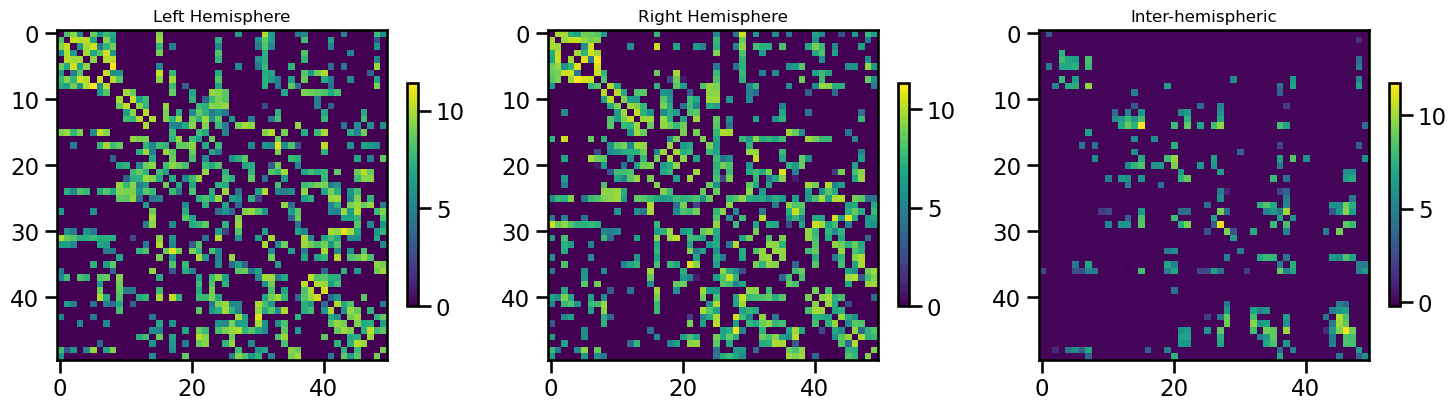


Pearson Correlations:
Left-Right Correlation: 0.197
Left-Inter Correlation: -0.032
Right-Inter Correlation: -0.021

Spearman Correlations:
Left-Right Correlation: 0.191
Left-Inter Correlation: -0.035
Right-Inter Correlation: -0.014


In [21]:
HCP_enigma_structural_count_left = HCP_enigma_structural_count[HCP_left_indices, :][:, HCP_left_indices]
HCP_enigma_structural_count_right = HCP_enigma_structural_count[HCP_right_indices, :][:, HCP_right_indices]
HCP_enigma_structural_count_inter = HCP_enigma_structural_count[HCP_left_indices, :][:, HCP_right_indices] 


# Create figure with 3 subplots
plt.figure(figsize=(15, 5))

# Plot left hemisphere connectivity
plt.subplot(131)
plt.imshow(HCP_enigma_structural_count_left, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('Left Hemisphere', fontsize=12)

# Plot right hemisphere connectivity 
plt.subplot(132)
plt.imshow(HCP_enigma_structural_count_right, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('Right Hemisphere', fontsize=12)

# Plot inter-hemispheric connectivity
plt.subplot(133)
plt.imshow(HCP_enigma_structural_count_inter, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('Inter-hemispheric', fontsize=12)

plt.tight_layout()
plt.show()
# Compute correlations between quadrants (excluding diagonal)
# Create masks to exclude diagonal
n_left = len(HCP_left_indices)
n_right = len(HCP_right_indices)
left_mask = ~np.eye(n_left, dtype=bool)
right_mask = ~np.eye(n_right, dtype=bool)

# Get flattened arrays for correlation
left_flat = HCP_enigma_structural_count_left[left_mask].flatten()
right_flat = HCP_enigma_structural_count_right[right_mask].flatten()
inter_flat = HCP_enigma_structural_count_inter.reshape(-1)

# Ensure arrays are same length by taking min length
min_len = min(len(left_flat), len(right_flat), len(inter_flat))
left_flat = left_flat[:min_len]
right_flat = right_flat[:min_len] 
inter_flat = inter_flat[:min_len]

# Compute correlations
# Pearson correlation using pearsonr
left_right_pearson, _ = pearsonr(left_flat, right_flat)
left_inter_pearson, _ = pearsonr(left_flat, inter_flat)
right_inter_pearson, _ = pearsonr(right_flat, inter_flat)

# Spearman correlation
left_right_spearman, _ = spearmanr(left_flat, right_flat)
left_inter_spearman, _ = spearmanr(left_flat, inter_flat)
right_inter_spearman, _ = spearmanr(right_flat, inter_flat)


print("\nPearson Correlations:")
print(f"Left-Right Correlation: {left_right_pearson:.3f}")
print(f"Left-Inter Correlation: {left_inter_pearson:.3f}")
print(f"Right-Inter Correlation: {right_inter_pearson:.3f}")

print("\nSpearman Correlations:")
print(f"Left-Right Correlation: {left_right_spearman:.3f}")
print(f"Left-Inter Correlation: {left_inter_spearman:.3f}")
print(f"Right-Inter Correlation: {right_inter_spearman:.3f}")


Function    

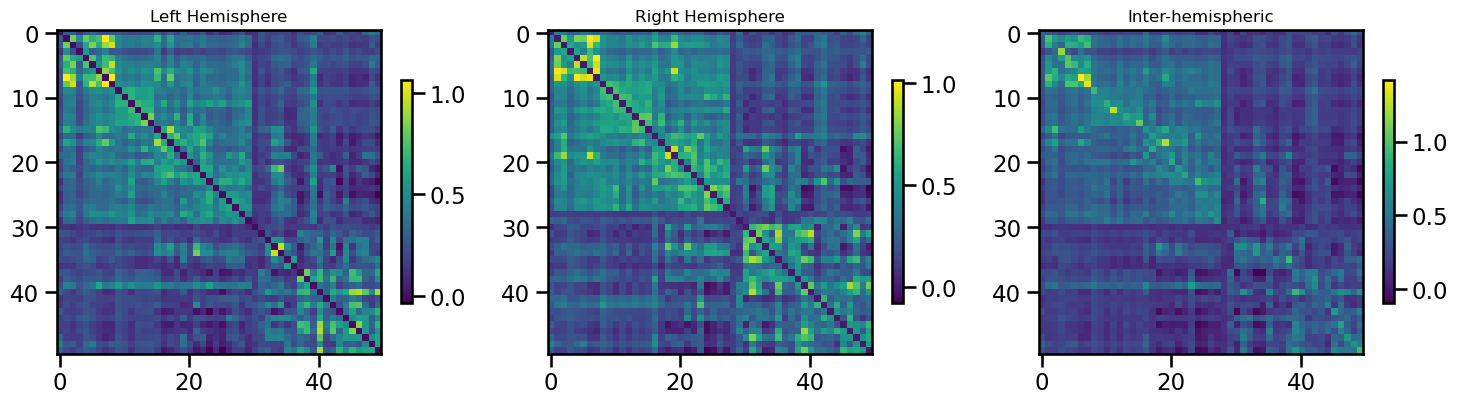


Pearson Correlations:
Left-Right Correlation: 0.503
Left-Inter Correlation: 0.098
Right-Inter Correlation: 0.053

Spearman Correlations:
Left-Right Correlation: 0.502
Left-Inter Correlation: 0.095
Right-Inter Correlation: 0.043


In [22]:
HCP_enigma_functional_conn

HCP_enigma_functional_conn_left = HCP_enigma_functional_conn[HCP_left_indices, :][:, HCP_left_indices]
HCP_enigma_functional_conn_right = HCP_enigma_functional_conn[HCP_right_indices, :][:, HCP_right_indices]
HCP_enigma_functional_conn_inter = HCP_enigma_functional_conn[HCP_left_indices, :][:, HCP_right_indices] 


# Create figure with 3 subplots
plt.figure(figsize=(15, 5))

# Plot left hemisphere connectivity
plt.subplot(131)
plt.imshow(HCP_enigma_functional_conn_left, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('Left Hemisphere', fontsize=12)

# Plot right hemisphere connectivity 
plt.subplot(132)
plt.imshow(HCP_enigma_functional_conn_right, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('Right Hemisphere', fontsize=12)

# Plot inter-hemispheric connectivity
plt.subplot(133)
plt.imshow(HCP_enigma_functional_conn_inter, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('Inter-hemispheric', fontsize=12)

plt.tight_layout()
plt.show()

# Compute correlations between quadrants (excluding diagonal)
# Create masks to exclude diagonal
n_left = len(HCP_left_indices)
n_right = len(HCP_right_indices)
left_mask = ~np.eye(n_left, dtype=bool)
right_mask = ~np.eye(n_right, dtype=bool)

# Get flattened arrays for correlation
left_flat = HCP_enigma_functional_conn_left[left_mask].flatten()
right_flat = HCP_enigma_functional_conn_right[right_mask].flatten()
inter_flat = HCP_enigma_functional_conn_inter.reshape(-1)

# Ensure arrays are same length by taking min length
min_len = min(len(left_flat), len(right_flat), len(inter_flat))
left_flat = left_flat[:min_len]
right_flat = right_flat[:min_len] 
inter_flat = inter_flat[:min_len]

# Compute correlations
# Pearson correlation using pearsonr
left_right_pearson, _ = pearsonr(left_flat, right_flat)
left_inter_pearson, _ = pearsonr(left_flat, inter_flat)
right_inter_pearson, _ = pearsonr(right_flat, inter_flat)

# Spearman correlation
left_right_spearman, _ = spearmanr(left_flat, right_flat)
left_inter_spearman, _ = spearmanr(left_flat, inter_flat)
right_inter_spearman, _ = spearmanr(right_flat, inter_flat)


print("\nPearson Correlations:")
print(f"Left-Right Correlation: {left_right_pearson:.3f}")
print(f"Left-Inter Correlation: {left_inter_pearson:.3f}")
print(f"Right-Inter Correlation: {right_inter_pearson:.3f}")

print("\nSpearman Correlations:")
print(f"Left-Right Correlation: {left_right_spearman:.3f}")
print(f"Left-Inter Correlation: {left_inter_spearman:.3f}")
print(f"Right-Inter Correlation: {right_inter_spearman:.3f}")


Transcriptome (AHBA ENIGMA cortical)

In [23]:
schaef_df = pd.read_csv( os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/atlas_info/schaef114.csv')
region_labels = schaef_df['label_x'].values
schaef_network_labels = schaef_df['network_label'].values
mni_coords = schaef_df[['mni_x', 'mni_y', 'mni_z']].values

In [24]:
AHBA_transcriptome = load_transcriptome(omit_subcortical=False)
AHBA_transcriptome_cortical = AHBA_transcriptome[:100, :]
AHBA_transcriptome_left = AHBA_transcriptome_cortical[HCP_left_indices, :]
AHBA_transcriptome_right = AHBA_transcriptome_cortical[HCP_right_indices, :]

# Flatten transcriptome data
left_flat = AHBA_transcriptome_left.reshape(-1)
right_flat = AHBA_transcriptome_right.reshape(-1)

# Compute correlation between left and right transcriptomes
lr_corr = np.corrcoef(left_flat, right_flat)[0,1]

print(f"Left-Right Transcriptome Correlation: {lr_corr:.3f}")
print("Shapes:")
print(f"Left: {AHBA_transcriptome_left.shape}")
print(f"Right: {AHBA_transcriptome_right.shape}")

# Compute pairwise correlations between left and right hemisphere regions
n_regions = AHBA_transcriptome_left.shape[0]
region_correlations = np.zeros((n_regions, n_regions))

for i in range(n_regions):
    for j in range(n_regions):
        region_correlations[i,j] = np.corrcoef(AHBA_transcriptome_left[i,:], 
                                             AHBA_transcriptome_right[j,:])[0,1]




Left-Right Transcriptome Correlation: 0.575
Shapes:
Left: (50, 11053)
Right: (50, 11053)


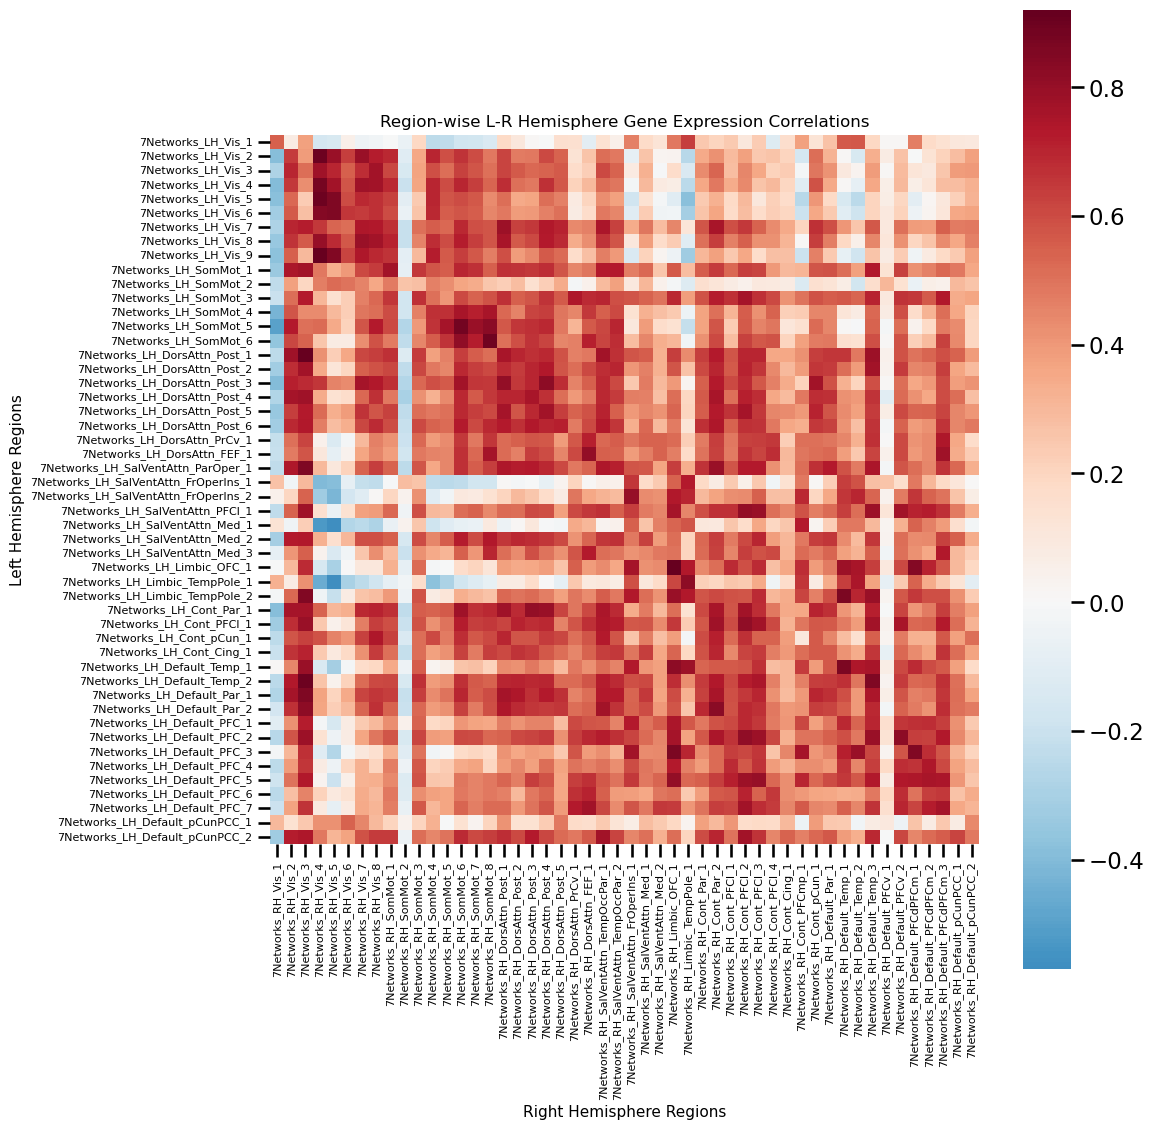


Correlation summary:
Mean: 0.411
Median: 0.470
Min: -0.570
Max: 0.921


In [25]:
# Create heatmap
plt.figure(figsize=(12,12))

# Plot heatmap with diagonal mask
sns.heatmap(region_correlations, cmap='RdBu_r', center=0,
            xticklabels=region_labels[HCP_right_indices],
            yticklabels=region_labels[HCP_left_indices],
            square=True)

plt.title('Region-wise L-R Hemisphere Gene Expression Correlations', fontsize=12)
plt.xlabel('Right Hemisphere Regions', fontsize=11)
plt.ylabel('Left Hemisphere Regions', fontsize=11)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nCorrelation summary:")
print(f"Mean: {np.mean(region_correlations):.3f}")
print(f"Median: {np.median(region_correlations):.3f}")
print(f"Min: {np.min(region_correlations):.3f}")
print(f"Max: {np.max(region_correlations):.3f}")

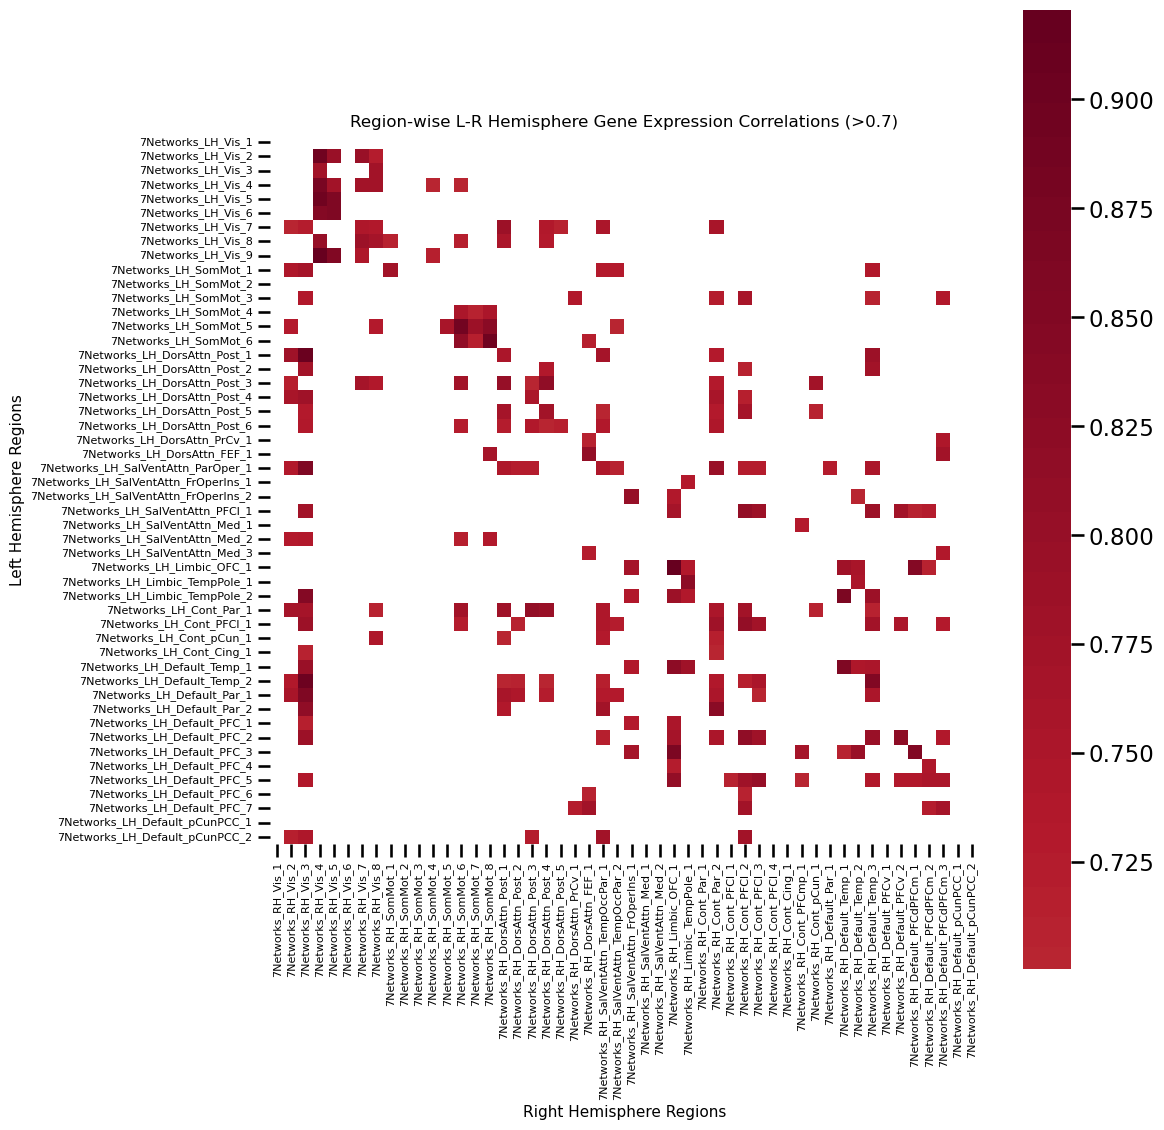

In [26]:
# Create heatmap
plt.figure(figsize=(12,12))

# Create mask for correlations <= 0.6
mask = region_correlations <= 0.7

# Plot heatmap with mask for low correlations
sns.heatmap(region_correlations, cmap='RdBu_r', center=0,
            xticklabels=region_labels[HCP_right_indices],
            yticklabels=region_labels[HCP_left_indices],
            square=True, mask=mask)

plt.title(f'Region-wise L-R Hemisphere Gene Expression Correlations (>{0.7:.1f})', fontsize=12)
plt.xlabel('Right Hemisphere Regions', fontsize=11)
plt.ylabel('Left Hemisphere Regions', fontsize=11)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()


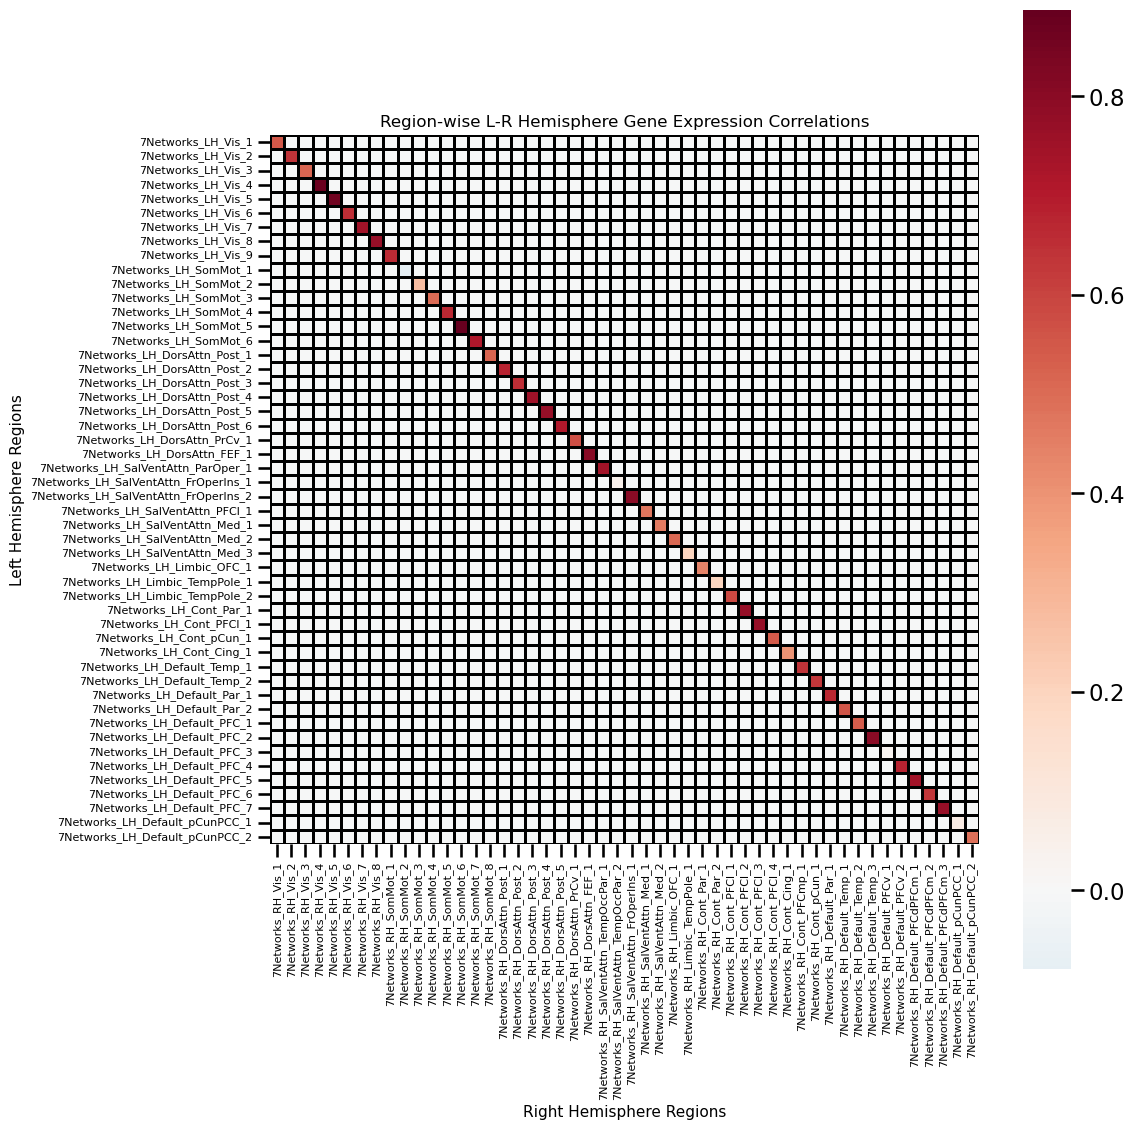

Mean diagonal correlation: 0.578


In [27]:
# Create heatmap
plt.figure(figsize=(12,12))

# Create mask for diagonal
mask = ~np.eye(region_correlations.shape[0], dtype=bool)

# Plot heatmap with diagonal mask
sns.heatmap(region_correlations, cmap='RdBu_r', center=0,
            xticklabels=region_labels[HCP_right_indices],
            yticklabels=region_labels[HCP_left_indices],
            square=True, mask=mask)

# Plot diagonal separately with black outline
sns.heatmap(region_correlations * np.eye(region_correlations.shape[0]),
            cmap='RdBu_r', center=0, 
            xticklabels=region_labels[HCP_right_indices],
            yticklabels=region_labels[HCP_left_indices],
            square=True, cbar=False,
            linewidths=1, linecolor='black')

plt.title('Region-wise L-R Hemisphere Gene Expression Correlations', fontsize=12)
plt.xlabel('Right Hemisphere Regions', fontsize=11)
plt.ylabel('Left Hemisphere Regions', fontsize=11)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

print(f"Mean diagonal correlation: {np.mean(np.diag(region_correlations)):.3f}")

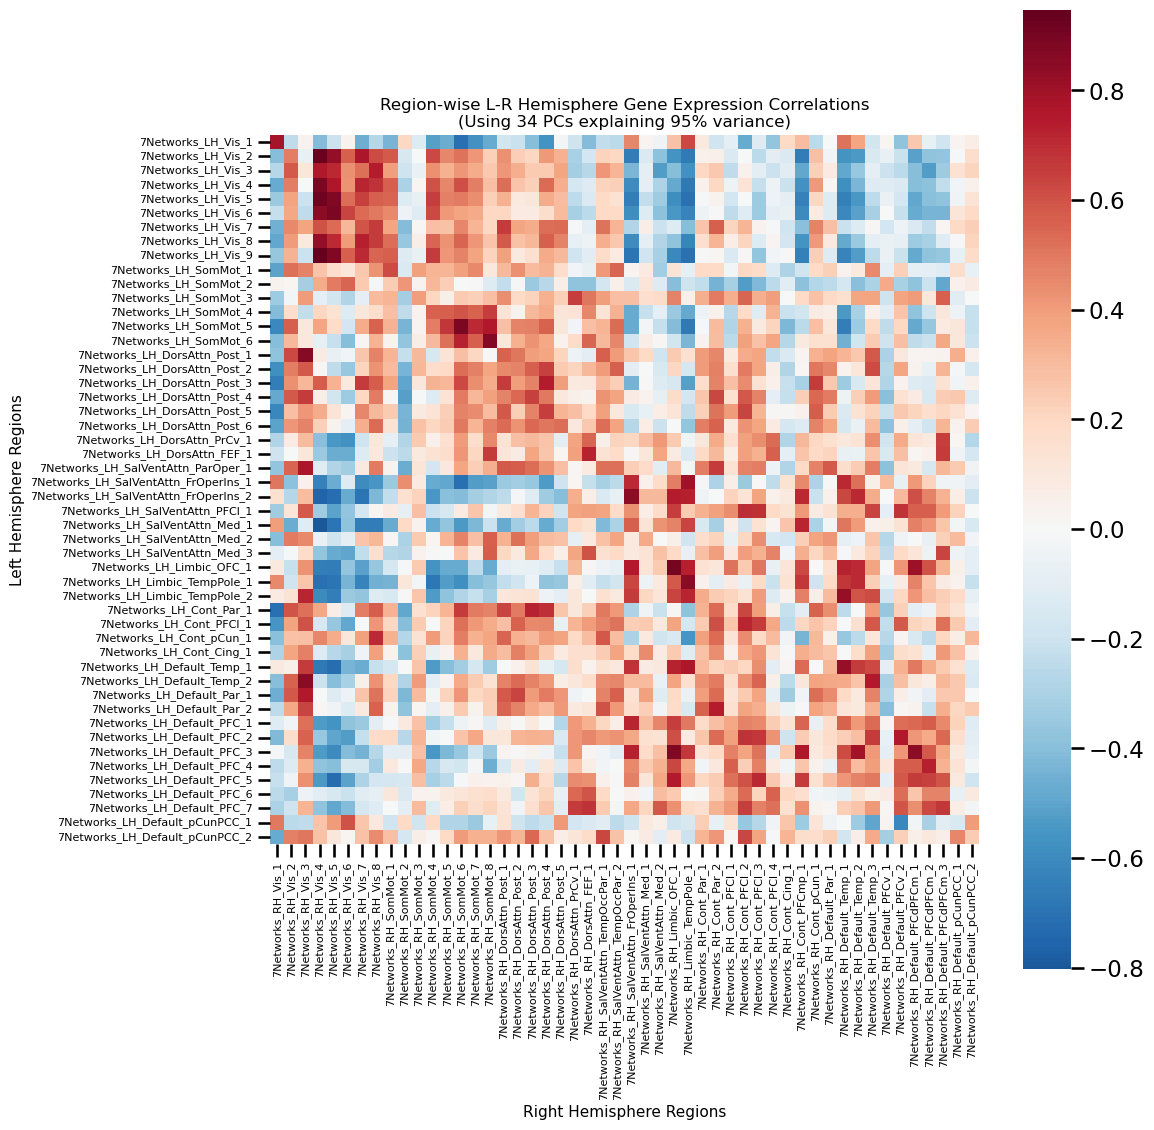


Correlation summary (based on 34 PCs):
Mean: 0.109
Median: 0.125
Min: -0.803
Max: 0.947
Mean diagonal correlation: 0.398


In [28]:
# Compute PCA of gene expression data - determine components for 95% variance
pca = PCA()
AHBA_pca_full = pca.fit_transform(AHBA_transcriptome)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# Split PCA results into left and right hemispheres
AHBA_cortical_PCA_left = AHBA_pca_full[HCP_left_indices, :n_components]
AHBA_cortical_PCA_right = AHBA_pca_full[HCP_right_indices, :n_components]

# Compute pairwise correlations between left and right hemisphere regions using PCA components
n_regions = AHBA_cortical_PCA_left.shape[0]
region_correlations = np.zeros((n_regions, n_regions))

for i in range(n_regions):
    for j in range(n_regions):
        region_correlations[i,j] = np.corrcoef(AHBA_cortical_PCA_left[i,:], 
                                             AHBA_cortical_PCA_right[j,:])[0,1]

# Create heatmap
plt.figure(figsize=(12,12))

# Plot heatmap
sns.heatmap(region_correlations, cmap='RdBu_r', center=0,
            xticklabels=region_labels[HCP_right_indices],
            yticklabels=region_labels[HCP_left_indices],
            square=True)

plt.title(f'Region-wise L-R Hemisphere Gene Expression Correlations\n(Using {n_components} PCs explaining 95% variance)', 
          fontsize=12)
plt.xlabel('Right Hemisphere Regions', fontsize=11)
plt.ylabel('Left Hemisphere Regions', fontsize=11)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nCorrelation summary (based on {n_components} PCs):")
print(f"Mean: {np.mean(region_correlations):.3f}")
print(f"Median: {np.median(region_correlations):.3f}")
print(f"Min: {np.min(region_correlations):.3f}")
print(f"Max: {np.max(region_correlations):.3f}")
print(f"Mean diagonal correlation: {np.mean(np.diag(region_correlations)):.3f}")


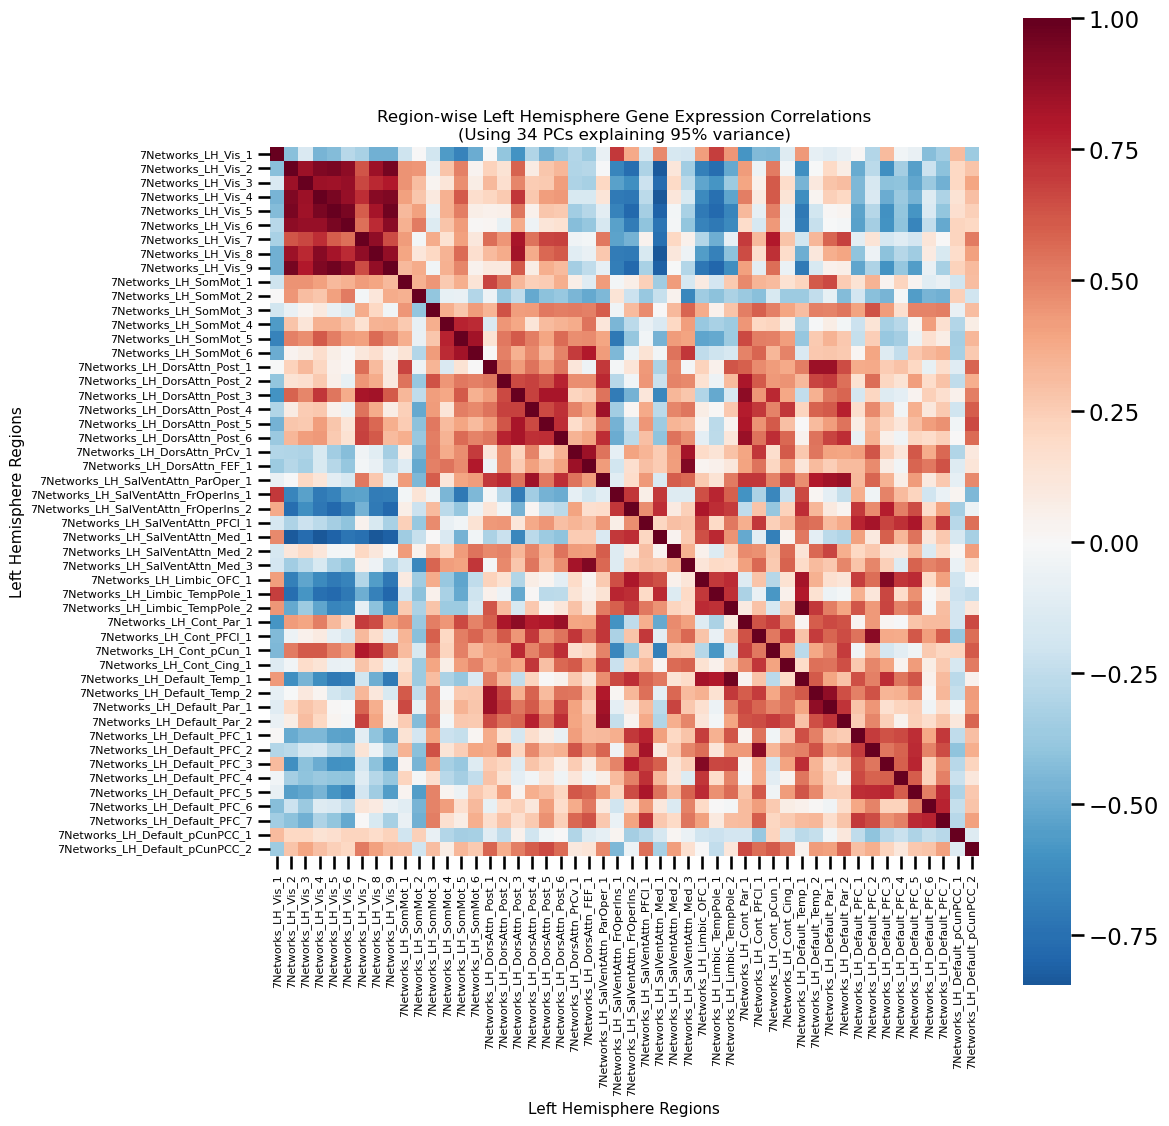


Correlation summary (based on 34 PCs):
Mean: 0.188
Median: 0.247
Min: -0.845
Max: 1.000
Mean diagonal correlation: 1.000


In [29]:
# Compute PCA of gene expression data - determine components for 95% variance
pca = PCA()
AHBA_pca_full = pca.fit_transform(AHBA_transcriptome)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# Get left hemisphere PCA results
AHBA_cortical_PCA_left = AHBA_pca_full[HCP_left_indices, :n_components]

# Compute pairwise correlations between left hemisphere regions using PCA components
n_regions = AHBA_cortical_PCA_left.shape[0]
region_correlations = np.zeros((n_regions, n_regions))

for i in range(n_regions):
    for j in range(n_regions):
        region_correlations[i,j] = np.corrcoef(AHBA_cortical_PCA_left[i,:], 
                                             AHBA_cortical_PCA_left[j,:])[0,1]

# Create heatmap
plt.figure(figsize=(12,12))

# Plot heatmap
sns.heatmap(region_correlations, cmap='RdBu_r', center=0,
            xticklabels=region_labels[HCP_left_indices],
            yticklabels=region_labels[HCP_left_indices],
            square=True)

plt.title(f'Region-wise Left Hemisphere Gene Expression Correlations\n(Using {n_components} PCs explaining 95% variance)', 
          fontsize=12)
plt.xlabel('Left Hemisphere Regions', fontsize=11)
plt.ylabel('Left Hemisphere Regions', fontsize=11)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nCorrelation summary (based on {n_components} PCs):")
print(f"Mean: {np.mean(region_correlations):.3f}")
print(f"Median: {np.median(region_correlations):.3f}")
print(f"Min: {np.min(region_correlations):.3f}")
print(f"Max: {np.max(region_correlations):.3f}")
print(f"Mean diagonal correlation: {np.mean(np.diag(region_correlations)):.3f}")


#### HCP-1200+UKBB

Structure

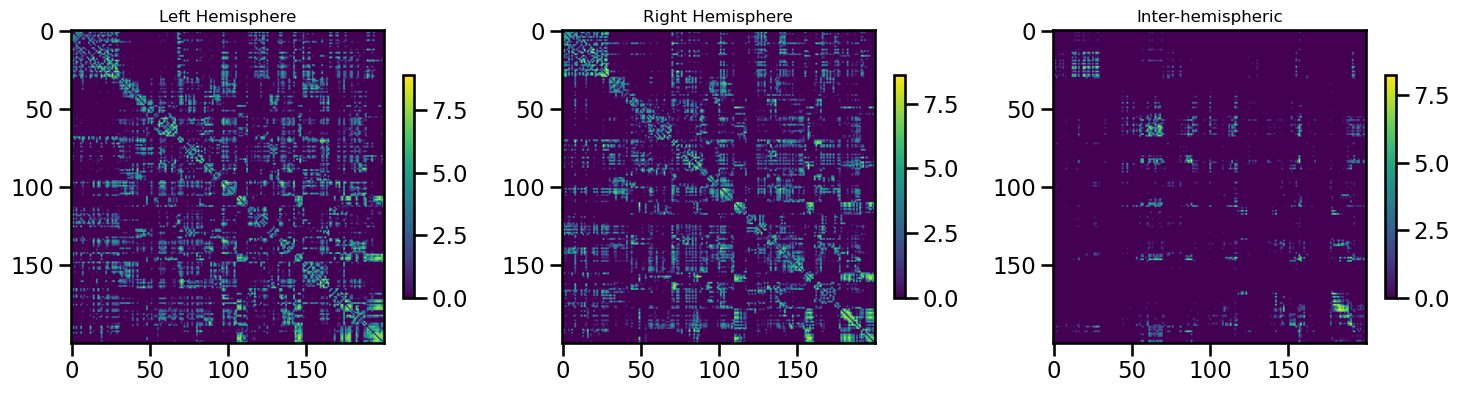


Pearson Correlations:
Left-Right Correlation: 0.107
Left-Inter Correlation: -0.003
Right-Inter Correlation: -0.005

Spearman Correlations:
Left-Right Correlation: 0.092
Left-Inter Correlation: 0.013
Right-Inter Correlation: 0.009


In [17]:
#HCP1200_S456_structural_count_cortical
#UKBB_S456_functional_conn_cortical

UKBB_S456_labels_cortical = pd.read_csv('./data/UKBB/schaefer456_atlas_info.txt', sep='\t')['label_7network'].tolist()[:400]

# Extract left and right indices based on hemisphere labels
left_indices = [i for i, label in enumerate(UKBB_S456_labels_cortical) if 'LH' in label]
right_indices = [i for i, label in enumerate(UKBB_S456_labels_cortical) if 'RH' in label]

# Create cortical structural connectivity matrices for left and right hemispheres
HCP1200_S456_structural_count_left = HCP1200_S456_structural_count_cortical[left_indices, :][:, left_indices]
HCP1200_S456_structural_count_right = HCP1200_S456_structural_count_cortical[right_indices, :][:, right_indices]
HCP1200_S456_structural_count_inter = HCP1200_S456_structural_count_cortical[left_indices, :][:, right_indices]

# Create figure with 3 subplots
plt.figure(figsize=(15, 5))

# Plot left hemisphere connectivity
plt.subplot(131)
plt.imshow(HCP1200_S456_structural_count_left, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('Left Hemisphere', fontsize=12)

# Plot right hemisphere connectivity 
plt.subplot(132)
plt.imshow(HCP1200_S456_structural_count_right, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('Right Hemisphere', fontsize=12)

# Plot inter-hemispheric connectivity
plt.subplot(133)
plt.imshow(HCP1200_S456_structural_count_inter, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('Inter-hemispheric', fontsize=12)

plt.tight_layout()
plt.show()

# Compute correlations between quadrants (excluding diagonal)
# Create masks to exclude diagonal
n_left = len(left_indices)
n_right = len(right_indices)
left_mask = ~np.eye(n_left, dtype=bool)
right_mask = ~np.eye(n_right, dtype=bool)

# Get flattened arrays for correlation
left_flat = HCP1200_S456_structural_count_left[left_mask].flatten()
right_flat = HCP1200_S456_structural_count_right[right_mask].flatten()
inter_flat = HCP1200_S456_structural_count_inter.reshape(-1)

# Ensure arrays are same length by taking min length
min_len = min(len(left_flat), len(right_flat), len(inter_flat))
left_flat = left_flat[:min_len]
right_flat = right_flat[:min_len]
inter_flat = inter_flat[:min_len]

# Compute correlations
# Pearson correlation using pearsonr
left_right_pearson, _ = pearsonr(left_flat, right_flat)
left_inter_pearson, _ = pearsonr(left_flat, inter_flat)
right_inter_pearson, _ = pearsonr(right_flat, inter_flat)

# Spearman correlation
left_right_spearman, _ = spearmanr(left_flat, right_flat)
left_inter_spearman, _ = spearmanr(left_flat, inter_flat)
right_inter_spearman, _ = spearmanr(right_flat, inter_flat)


print("\nPearson Correlations:")
print(f"Left-Right Correlation: {left_right_pearson:.3f}")
print(f"Left-Inter Correlation: {left_inter_pearson:.3f}")
print(f"Right-Inter Correlation: {right_inter_pearson:.3f}")

print("\nSpearman Correlations:")
print(f"Left-Right Correlation: {left_right_spearman:.3f}")
print(f"Left-Inter Correlation: {left_inter_spearman:.3f}")
print(f"Right-Inter Correlation: {right_inter_spearman:.3f}")


Function 

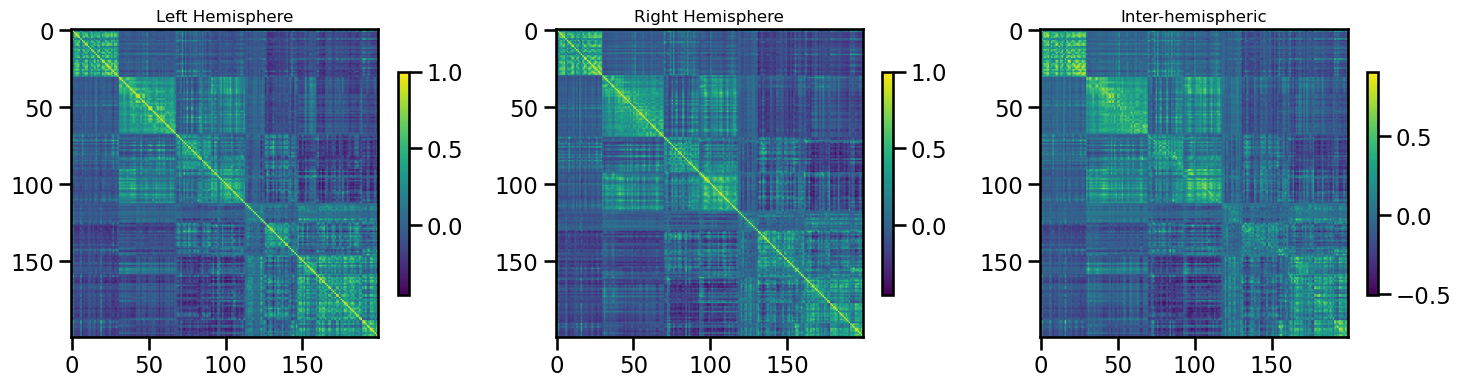


Pearson Correlations:
Left-Right Correlation: 0.502
Left-Inter Correlation: 0.043
Right-Inter Correlation: 0.066

Spearman Correlations:
Left-Right Correlation: 0.461
Left-Inter Correlation: 0.042
Right-Inter Correlation: 0.070


In [18]:
UKBB_S456_labels_cortical = pd.read_csv('./data/UKBB/schaefer456_atlas_info.txt', sep='\t')['label_7network'].tolist()[:400]

# Extract left and right indices based on hemisphere labels
left_indices = [i for i, label in enumerate(UKBB_S456_labels_cortical) if 'LH' in label]
right_indices = [i for i, label in enumerate(UKBB_S456_labels_cortical) if 'RH' in label]

# Create cortical structural connectivity matrices for left and right hemispheres
HCP1200_S456_functional_conn_left = UKBB_S456_functional_conn_cortical[left_indices, :][:, left_indices]
HCP1200_S456_functional_conn_right = UKBB_S456_functional_conn_cortical[right_indices, :][:, right_indices]
HCP1200_S456_functional_conn_inter = UKBB_S456_functional_conn_cortical[left_indices, :][:, right_indices]

# Create figure with 3 subplots
plt.figure(figsize=(15, 5))

# Plot left hemisphere connectivity
plt.subplot(131)
plt.imshow(HCP1200_S456_functional_conn_left, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('Left Hemisphere', fontsize=12)

# Plot right hemisphere connectivity 
plt.subplot(132)
plt.imshow(HCP1200_S456_functional_conn_right, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('Right Hemisphere', fontsize=12)

# Plot inter-hemispheric connectivity
plt.subplot(133)
plt.imshow(HCP1200_S456_functional_conn_inter, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('Inter-hemispheric', fontsize=12)

plt.tight_layout()
plt.show()

# Compute correlations between quadrants (excluding diagonal)
# Create masks to exclude diagonal
n_left = len(left_indices)
n_right = len(right_indices)
left_mask = ~np.eye(n_left, dtype=bool)
right_mask = ~np.eye(n_right, dtype=bool)

# Get flattened arrays for correlation
left_flat = HCP1200_S456_functional_conn_left[left_mask].flatten()
right_flat = HCP1200_S456_functional_conn_right[right_mask].flatten()
inter_flat = HCP1200_S456_functional_conn_inter.reshape(-1)

# Ensure arrays are same length by taking min length
min_len = min(len(left_flat), len(right_flat), len(inter_flat))
left_flat = left_flat[:min_len]
right_flat = right_flat[:min_len]
inter_flat = inter_flat[:min_len]

# Compute correlations
# Pearson correlation using pearsonr
left_right_pearson, _ = pearsonr(left_flat, right_flat)
left_inter_pearson, _ = pearsonr(left_flat, inter_flat)
right_inter_pearson, _ = pearsonr(right_flat, inter_flat)

# Spearman correlation
left_right_spearman, _ = spearmanr(left_flat, right_flat)
left_inter_spearman, _ = spearmanr(left_flat, inter_flat)
right_inter_spearman, _ = spearmanr(right_flat, inter_flat)


print("\nPearson Correlations:")
print(f"Left-Right Correlation: {left_right_pearson:.3f}")
print(f"Left-Inter Correlation: {left_inter_pearson:.3f}")
print(f"Right-Inter Correlation: {right_inter_pearson:.3f}")

print("\nSpearman Correlations:")
print(f"Left-Right Correlation: {left_right_spearman:.3f}")
print(f"Left-Inter Correlation: {left_inter_spearman:.3f}")
print(f"Right-Inter Correlation: {right_inter_spearman:.3f}")


Transcriptome (AHBA S456 cortical)